In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("🛍️ Mall Customer Segmentation Analysis")
print("=" * 45)


🛍️ Mall Customer Segmentation Analysis


In [4]:
print("\n📊 Step 1: Loading and Exploring Data")
print("-" * 40)
df = pd.read_csv('Mall_Customers.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")



📊 Step 1: Loading and Exploring Data
----------------------------------------
Dataset shape: (200, 5)
Columns: ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']


In [5]:
print("\n📋 Dataset Info:")
df.info()

print(f"\n❌ Missing values:\n{df.isnull().sum()}")



📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

❌ Missing values:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [7]:
print("\n🔍 First 10 rows:")
display(df.head(10))
print("\n📈 Statistical Summary:")
display(df.describe())
print(f"\nGender distribution:\n{df['Gender'].value_counts()}")


🔍 First 10 rows:


CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
5           6  Female   22                  17                      76
6           7  Female   35                  18                       6
7           8  Female   23                  18                      94
8           9    Male   64                  19                       3
9          10  Female   30                  19                      72


📈 Statistical Summary:


CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


Gender distribution:
Gender
Female    112
Male       88
Name: count, dtype: int64



🔍 Step 2: Data Exploration
--------------------------------


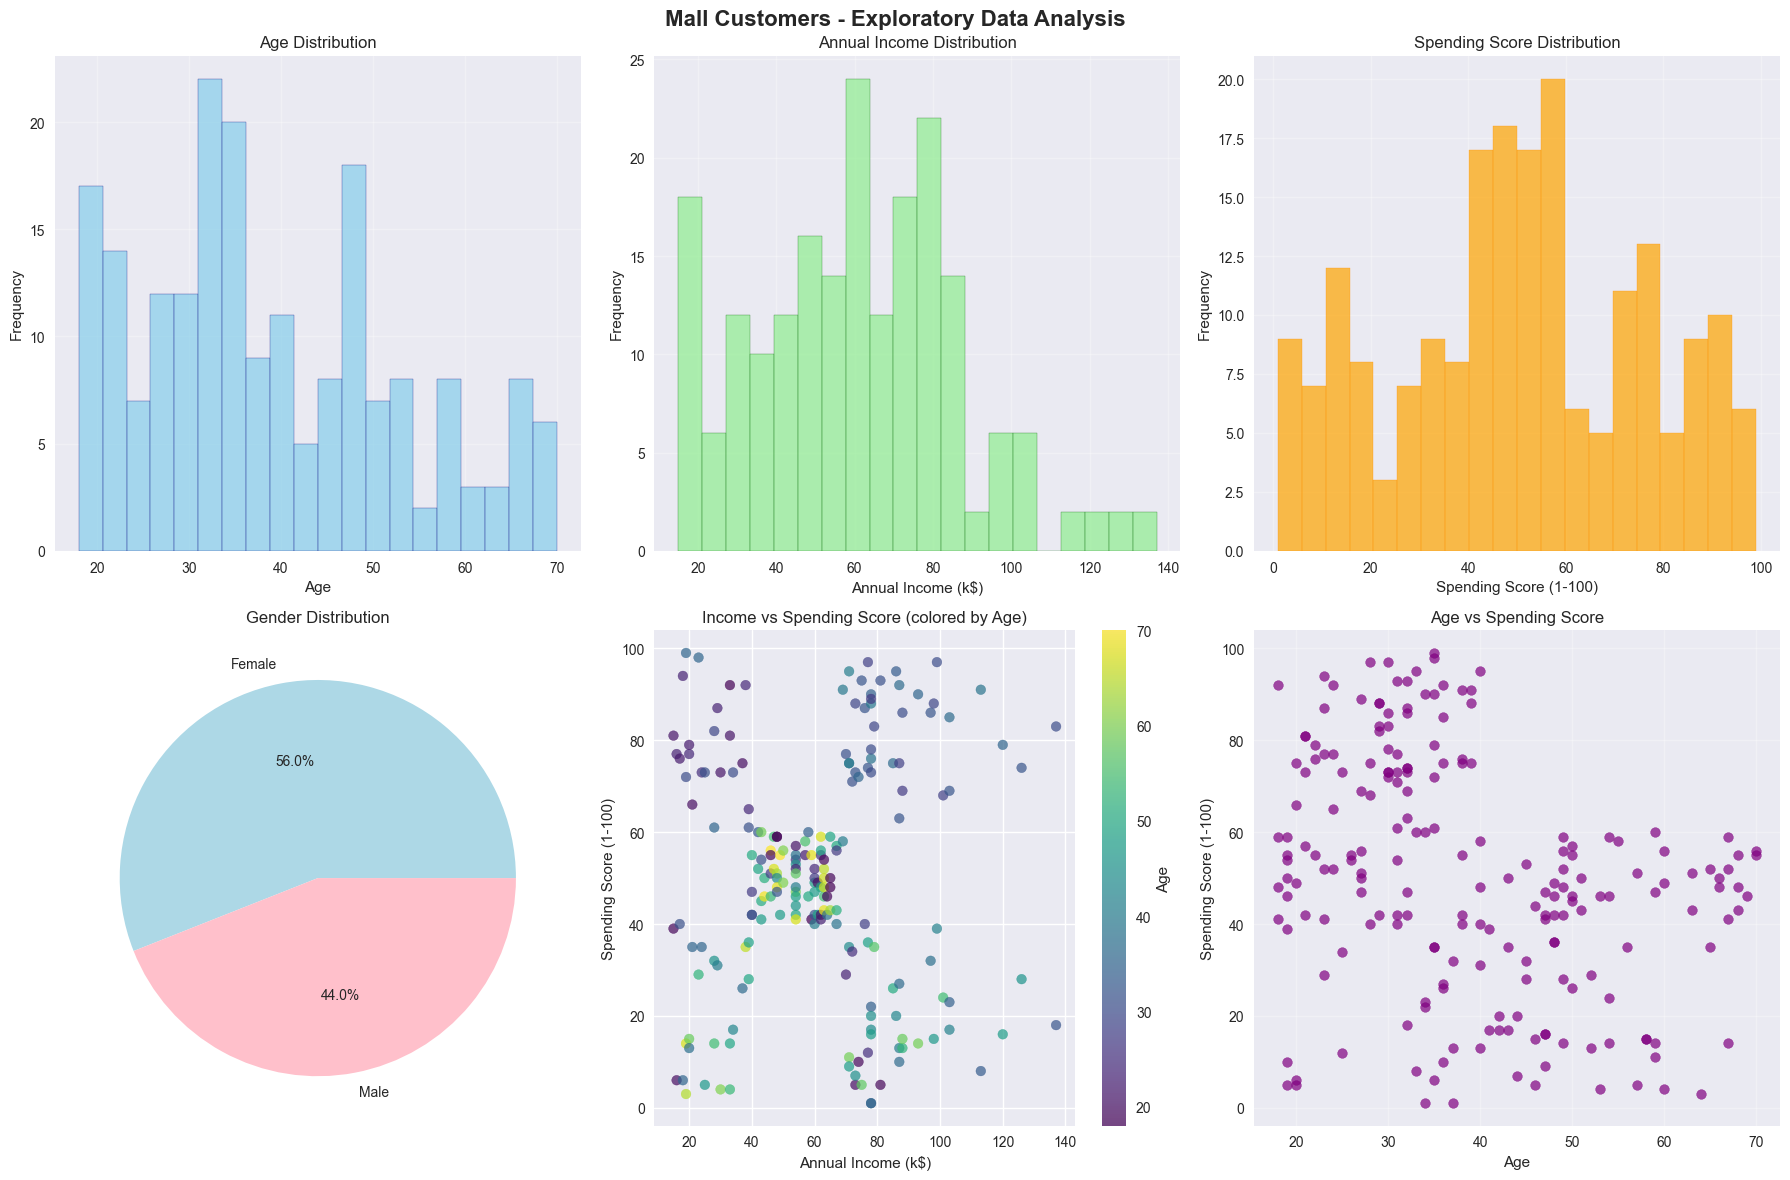

In [8]:
print("\n🔍 Step 2: Data Exploration")
print("-" * 32)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Mall Customers - Exploratory Data Analysis', fontsize=16, fontweight='bold')
axes[0, 0].hist(df['Age'], bins=20, alpha=0.7, color='skyblue', edgecolor='navy')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 1].hist(df['Annual Income (k$)'], bins=20, alpha=0.7, color='lightgreen', edgecolor='darkgreen')
axes[0, 1].set_title('Annual Income Distribution')
axes[0, 1].set_xlabel('Annual Income (k$)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 2].hist(df['Spending Score (1-100)'], bins=20, alpha=0.7, color='orange', edgecolor='darkorange')
axes[0, 2].set_title('Spending Score Distribution')
axes[0, 2].set_xlabel('Spending Score (1-100)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].grid(True, alpha=0.3)
gender_counts = df['Gender'].value_counts()
axes[1, 0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', 
               colors=['lightblue', 'pink'])
axes[1, 0].set_title('Gender Distribution')
scatter = axes[1, 1].scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], 
                            c=df['Age'], cmap='viridis', alpha=0.7)
axes[1, 1].set_xlabel('Annual Income (k$)')
axes[1, 1].set_ylabel('Spending Score (1-100)')
axes[1, 1].set_title('Income vs Spending Score (colored by Age)')
plt.colorbar(scatter, ax=axes[1, 1], label='Age')
axes[1, 2].scatter(df['Age'], df['Spending Score (1-100)'], alpha=0.7, color='purple')
axes[1, 2].set_xlabel('Age')
axes[1, 2].set_ylabel('Spending Score (1-100)')
axes[1, 2].set_title('Age vs Spending Score')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('customer_exploration.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
print("\n🛠️ Step 3: Data Preprocessing")
print("-" * 33)
clustering_features = ['Annual Income (k$)', 'Spending Score (1-100)']
X = df[clustering_features].copy()

print(f"Features for clustering: {clustering_features}")
print(f"Clustering data shape: {X.shape}")
print(f"\nMissing values in clustering features:\n{X.isnull().sum()}")



🛠️ Step 3: Data Preprocessing
---------------------------------
Features for clustering: ['Annual Income (k$)', 'Spending Score (1-100)']
Clustering data shape: (200, 2)

Missing values in clustering features:
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✅ Features scaled using StandardScaler")
print(f"Original feature ranges:")
for col in clustering_features:
    print(f"   {col}: {X[col].min():.1f} - {X[col].max():.1f}")

print(f"\nScaled feature ranges:")
for i, col in enumerate(clustering_features):
    print(f"   {col}: {X_scaled[:, i].min():.2f} - {X_scaled[:, i].max():.2f}")



✅ Features scaled using StandardScaler
Original feature ranges:
   Annual Income (k$): 15.0 - 137.0
   Spending Score (1-100): 1.0 - 99.0

Scaled feature ranges:
   Annual Income (k$): -1.74 - 2.92
   Spending Score (1-100): -1.91 - 1.89



🎯 Step 4: Determining Optimal Number of Clusters
--------------------------------------------------
Running Elbow Method...


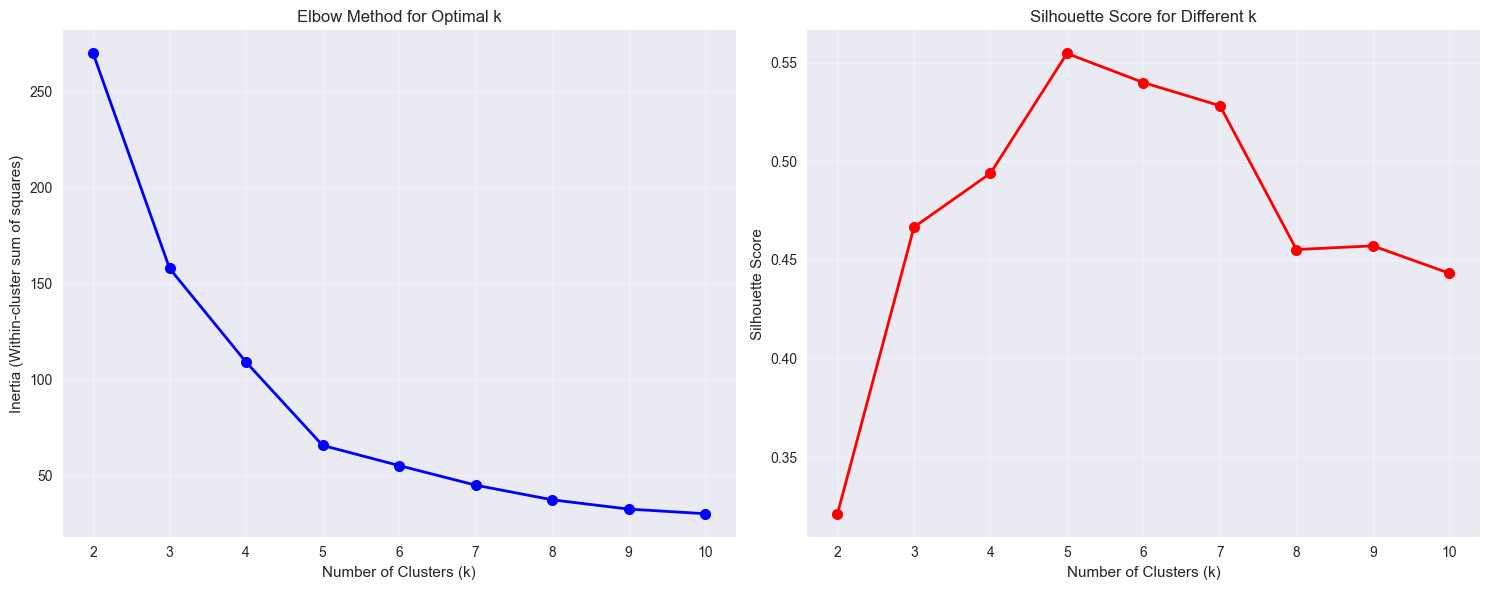

In [12]:
print("\n🎯 Step 4: Determining Optimal Number of Clusters")
print("-" * 50)
print("Running Elbow Method...")
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True, alpha=0.3)
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Different k')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('optimal_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"\n📊 Clustering Analysis Results:")
print(f"   Best k by Silhouette Score: {optimal_k_silhouette}")
print(f"   Silhouette Score: {max(silhouette_scores):.3f}")



📊 Clustering Analysis Results:
   Best k by Silhouette Score: 5
   Silhouette Score: 0.555


In [14]:
print(f"\n📈 All Silhouette Scores:")
for k, score in zip(k_range, silhouette_scores):
    print(f"   k={k}: {score:.3f}")



📈 All Silhouette Scores:
   k=2: 0.321
   k=3: 0.467
   k=4: 0.494
   k=5: 0.555
   k=6: 0.540
   k=7: 0.528
   k=8: 0.455
   k=9: 0.457
   k=10: 0.443


In [15]:
print("\n🤖 Step 5: Applying K-Means Clustering")
print("-" * 40)
optimal_k = 5
print(f"Using k = {optimal_k} clusters")
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)


🤖 Step 5: Applying K-Means Clustering
----------------------------------------
Using k = 5 clusters


In [16]:
df_clustered = df.copy()
df_clustered['Cluster'] = cluster_labels

print(f"✅ K-Means clustering completed")
print(f"   Number of clusters: {optimal_k}")
print(f"   Silhouette score: {silhouette_score(X_scaled, cluster_labels):.3f}")
print(f"\n📊 Cluster Distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = count / len(cluster_labels) * 100
    print(f"   Cluster {cluster}: {count} customers ({percentage:.1f}%)")


✅ K-Means clustering completed
   Number of clusters: 5
   Silhouette score: 0.555

📊 Cluster Distribution:
   Cluster 0: 81 customers (40.5%)
   Cluster 1: 39 customers (19.5%)
   Cluster 2: 22 customers (11.0%)
   Cluster 3: 35 customers (17.5%)
   Cluster 4: 23 customers (11.5%)


In [17]:
print("\n📋 Step 6: Cluster Analysis")
print("-" * 30)
cluster_analysis = df_clustered.groupby('Cluster').agg({
    'Age': ['mean', 'std'],
    'Annual Income (k$)': ['mean', 'std'],
    'Spending Score (1-100)': ['mean', 'std'],
    'Gender': lambda x: x.value_counts().index[0]  # Mode
}).round(2)

print("📊 Cluster Characteristics:")
display(cluster_analysis)



📋 Step 6: Cluster Analysis
------------------------------
📊 Cluster Characteristics:


Age        Annual Income (k$)        Spending Score (1-100)         \
          mean    std               mean    std                   mean    std   
Cluster                                                                         
0        42.72  16.45              55.30   8.99                  49.52   6.53   
1        32.69   3.73              86.54  16.31                  82.13   9.36   
2        25.27   5.26              25.73   7.57                  79.36  10.50   
3        41.11  11.34              88.20  16.40                  17.11   9.95   
4        45.22  13.23              26.30   7.89                  20.91  13.02   

          Gender  
        <lambda>  
Cluster           
0         Female  
1         Female  
2         Female  
3           Male  
4         Female

In [18]:
cluster_profiles = {}
for cluster in range(optimal_k):
    cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
    profile = {
        'size': len(cluster_data),
        'avg_age': cluster_data['Age'].mean(),
        'avg_income': cluster_data['Annual Income (k$)'].mean(),
        'avg_spending': cluster_data['Spending Score (1-100)'].mean(),
        'dominant_gender': cluster_data['Gender'].mode()[0]
    }
    cluster_profiles[cluster] = profile

In [19]:
print(f"\n🎯 Cluster Profiles:")
for cluster, profile in cluster_profiles.items():
    print(f"   Cluster {cluster}: {profile['size']} customers")
    print(f"      Age: {profile['avg_age']:.1f}, Income: {profile['avg_income']:.1f}k$")
    print(f"      Spending: {profile['avg_spending']:.1f}, Gender: {profile['dominant_gender']}")



🎯 Cluster Profiles:
   Cluster 0: 81 customers
      Age: 42.7, Income: 55.3k$
      Spending: 49.5, Gender: Female
   Cluster 1: 39 customers
      Age: 32.7, Income: 86.5k$
      Spending: 82.1, Gender: Female
   Cluster 2: 22 customers
      Age: 25.3, Income: 25.7k$
      Spending: 79.4, Gender: Female
   Cluster 3: 35 customers
      Age: 41.1, Income: 88.2k$
      Spending: 17.1, Gender: Male
   Cluster 4: 23 customers
      Age: 45.2, Income: 26.3k$
      Spending: 20.9, Gender: Female



📈 Step 7: Cluster Visualization
-----------------------------------


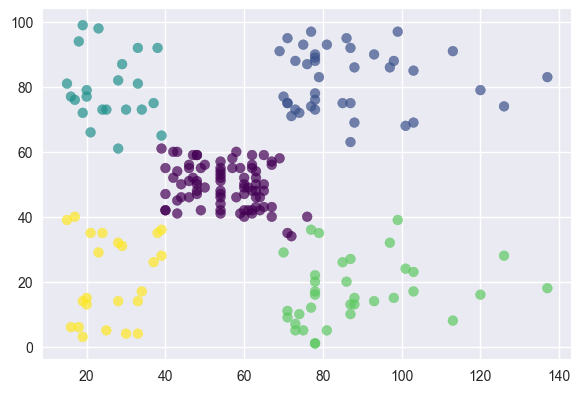

In [20]:
print("\n📈 Step 7: Cluster Visualization")
print("-" * 35)
plt.figure(figsize=(15, 10))

# Main scatter plot
plt.subplot(2, 2, 1)
scatter = plt.scatter(df_clustered['Annual Income (k$)'], 
                     df_clustered['Spending Score (1-100)'],
                     c=df_clustered['Cluster'], 
                     cmap='viridis', 
                     alpha=0.7, 
                     s=50)

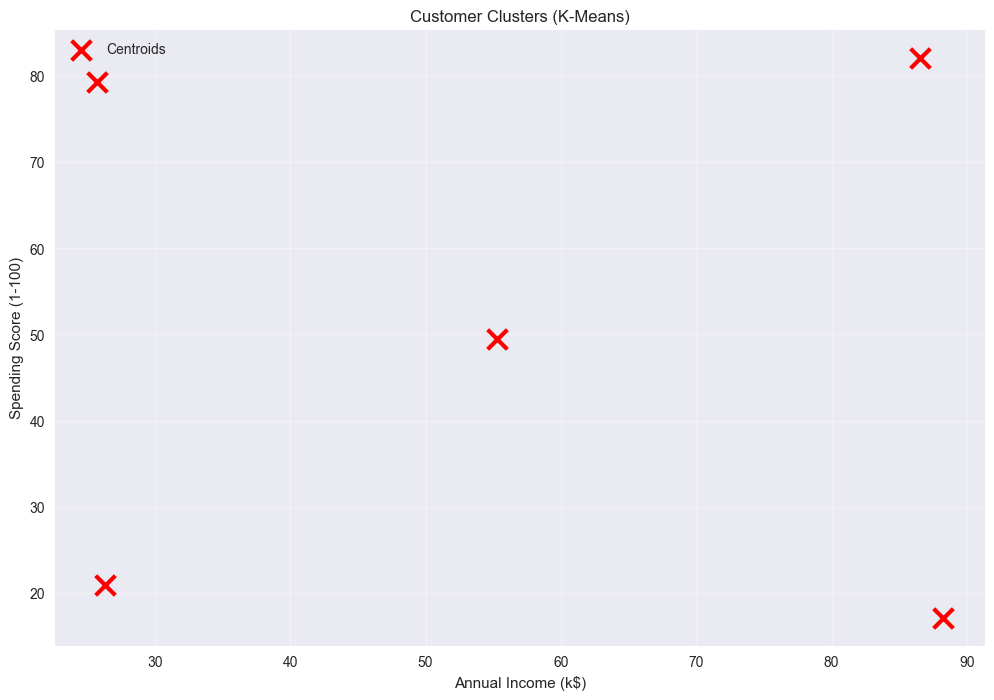

In [21]:
centers = scaler.inverse_transform(kmeans_final.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], 
           c='red', marker='x', s=200, linewidths=3, label='Centroids')

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Customer Clusters (K-Means)')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)

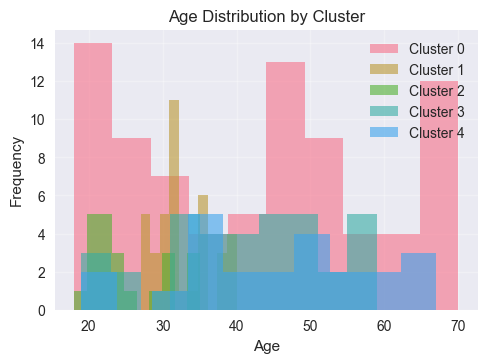

In [22]:
plt.subplot(2, 2, 2)
for cluster in range(optimal_k):
    cluster_ages = df_clustered[df_clustered['Cluster'] == cluster]['Age']
    plt.hist(cluster_ages, alpha=0.6, label=f'Cluster {cluster}', bins=10)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution by Cluster')
plt.legend()
plt.grid(True, alpha=0.3)

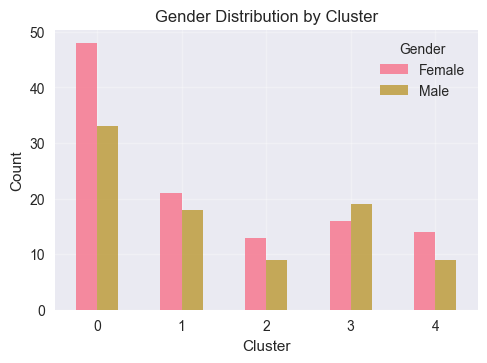

In [23]:
plt.subplot(2, 2, 3)
gender_cluster = df_clustered.groupby(['Cluster', 'Gender']).size().unstack(fill_value=0)
gender_cluster.plot(kind='bar', ax=plt.gca(), alpha=0.8)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Gender Distribution by Cluster')
plt.xticks(rotation=0)
plt.legend(title='Gender')
plt.grid(True, alpha=0.3)

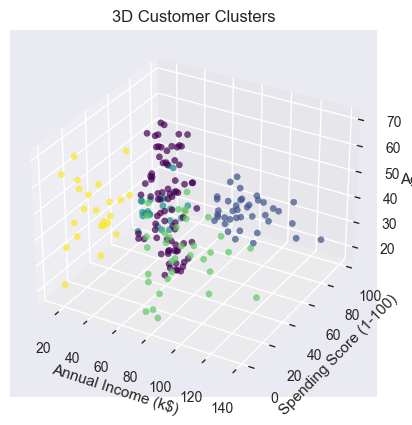

In [24]:
ax = plt.subplot(2, 2, 4, projection='3d')
scatter_3d = ax.scatter(df_clustered['Annual Income (k$)'], 
                       df_clustered['Spending Score (1-100)'],
                       df_clustered['Age'],
                       c=df_clustered['Cluster'], 
                       cmap='viridis', 
                       alpha=0.7)
ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Spending Score (1-100)')
ax.set_zlabel('Age')
ax.set_title('3D Customer Clusters')

plt.tight_layout()
plt.savefig('cluster_visualization.png', dpi=150, bbox_inches='tight')
plt.show()



🚀 Step 8: Bonus - DBSCAN Clustering
--------------------------------------
Applying DBSCAN clustering...
   eps=0.3: 8 clusters, silhouette=0.316
   eps=0.5: 3 clusters, silhouette=0.350

✅ Best DBSCAN: eps=0.5, silhouette=0.350
   Number of clusters: 3
   Noise points: 8


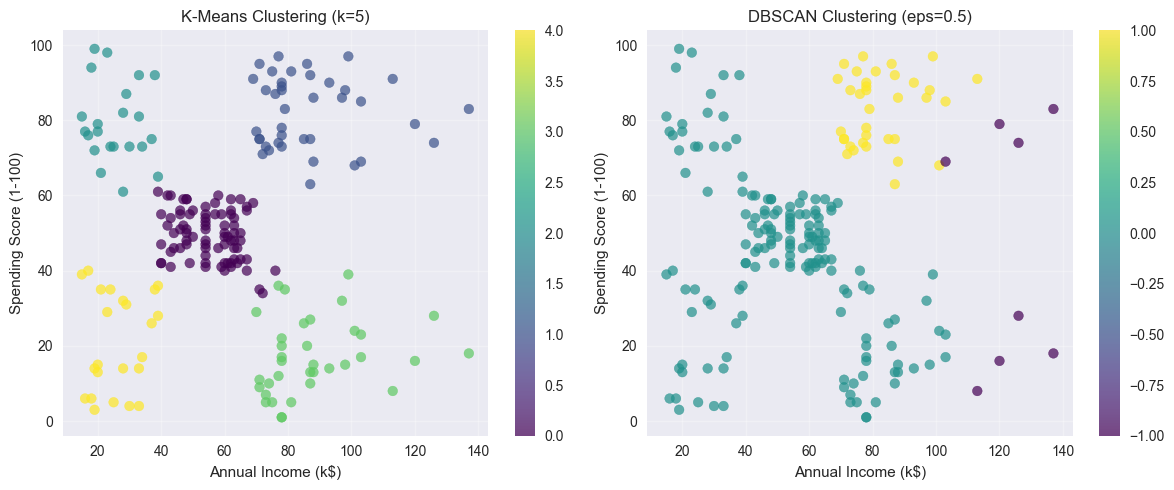

In [26]:
print("\n🚀 Step 8: Bonus - DBSCAN Clustering")
print("-" * 38)
print("Applying DBSCAN clustering...")
eps_values = [0.3, 0.5, 0.7, 1.0]
best_dbscan = None
best_score = -1
best_eps = None
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    
    if len(set(dbscan_labels)) > 1:  # More than just noise
        score = silhouette_score(X_scaled, dbscan_labels)
        print(f"   eps={eps}: {len(set(dbscan_labels))} clusters, silhouette={score:.3f}")
        
        if score > best_score:
            best_score = score
            best_dbscan = dbscan
            best_eps = eps

if best_dbscan is not None:
    dbscan_labels = best_dbscan.fit_predict(X_scaled)
    df_dbscan = df.copy()
    df_dbscan['Cluster'] = dbscan_labels
    
    print(f"\n✅ Best DBSCAN: eps={best_eps}, silhouette={best_score:.3f}")
    print(f"   Number of clusters: {len(set(dbscan_labels))}")
    print(f"   Noise points: {sum(dbscan_labels == -1)}")
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    scatter_kmeans = plt.scatter(df_clustered['Annual Income (k$)'], 
                                df_clustered['Spending Score (1-100)'],
                                c=df_clustered['Cluster'], 
                                cmap='viridis', alpha=0.7)
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending Score (1-100)')
    plt.title(f'K-Means Clustering (k={optimal_k})')
    plt.colorbar(scatter_kmeans)
    plt.grid(True, alpha=0.3)
    plt.subplot(1, 2, 2)
    scatter_dbscan = plt.scatter(df_dbscan['Annual Income (k$)'], 
                                df_dbscan['Spending Score (1-100)'],
                                c=df_dbscan['Cluster'], 
                                cmap='viridis', alpha=0.7)
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending Score (1-100)')
    plt.title(f'DBSCAN Clustering (eps={best_eps})')
    plt.colorbar(scatter_dbscan)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('dbscan_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    

In [27]:
print("\n💾 Step 9: Saving Models and Data")
print("-" * 35)
joblib.dump(kmeans_final, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("✅ Saved K-Means model and scaler")

if best_dbscan is not None:
    joblib.dump(best_dbscan, 'dbscan_model.pkl')
    print("✅ Saved DBSCAN model")
clustering_info = {
    'optimal_k': optimal_k,
    'silhouette_score_kmeans': silhouette_score(X_scaled, cluster_labels),
    'cluster_profiles': cluster_profiles,
    'feature_columns': clustering_features,
    'inertias': inertias,
    'silhouette_scores': silhouette_scores,
    'k_range': list(k_range)
}
if best_dbscan is not None:
    clustering_info['dbscan_eps'] = best_eps
    clustering_info['silhouette_score_dbscan'] = best_score

joblib.dump(clustering_info, 'clustering_info.pkl')
print("✅ Saved clustering information")


💾 Step 9: Saving Models and Data
-----------------------------------
✅ Saved K-Means model and scaler
✅ Saved DBSCAN model
✅ Saved clustering information
